In [ ]:
import torch

# Check version
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# If available, check the CUDA device
if torch.cuda.is_available():
    print("CUDA device name:", torch.cuda.get_device_name(0))


PyTorch version: 2.6.0+cu124
CUDA available: False


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, ConcatDataset
import cv2
import pickle

def load_intrinsics(intrinsics_path=None):
    if intrinsics_path and os.path.exists(intrinsics_path):
        with open(intrinsics_path, 'r') as f:
            lines = f.readlines()
        K = []
        for line in lines:
            nums = list(map(float, line.strip().split()))
            K.append(nums)
        K = np.array(K)
        print(f"Loaded intrinsics from {intrinsics_path}:")
        print(K)
    else:
        print("Using default intrinsics. Cannot load from file:", intrinsics_path)
        K = np.array([[570.3422, 0, 320],
                      [0, 570.3422, 240],
                      [0, 0, 1]])
        print(K)
    return K

def depth_to_pointcloud(depth_img, intrinsics):
    fx, fy = intrinsics[0, 0], intrinsics[1, 1]
    cx, cy = intrinsics[0, 2], intrinsics[1, 2]
    height, width = depth_img.shape
    u, v = np.meshgrid(np.arange(width), np.arange(height))
    Z = depth_img.astype(np.float32)
    X = (u - cx) * Z / fx
    Y = (v - cy) * Z / fy
    pointcloud = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)
    valid = (Z.reshape(-1) > 0)
    pointcloud = pointcloud[valid]
    return pointcloud

def downsample_pointcloud(pointcloud, num_points=1024):
    N = pointcloud.shape[0]
    if N >= num_points:
        indices = np.random.choice(N, num_points, replace=False)
    else:
        indices = np.random.choice(N, num_points, replace=True)
    return pointcloud[indices]

def random_augmentation(sample):
    # Augmentation function; can be set to None if not used.
    pointcloud = sample["pointcloud"].numpy()
    angle = np.random.uniform(0, 2*np.pi)
    R = np.array([[np.cos(angle), -np.sin(angle), 0],
                  [np.sin(angle),  np.cos(angle), 0],
                  [0,             0,              1]])
    pointcloud = pointcloud @ R.T
    scale = np.random.uniform(0.9, 1.1)
    pointcloud *= scale
    jitter = np.random.normal(0, 0.01, pointcloud.shape)
    pointcloud += jitter
    sample["pointcloud"] = torch.from_numpy(pointcloud).float()
    return sample

class TableClassificationDataset(Dataset):
    def __init__(self, root_dir, depth_folder="depth", annotation_path="tabletop_labels.dat",
                 intrinsics_path=None, num_points=1024, transform=None, verbose=False):
        super().__init__()
        self.root_dir = root_dir
        self.depth_dir = os.path.join(root_dir, depth_folder)
        self.annotation_path = os.path.join(root_dir, annotation_path)
        self.num_points = num_points
        self.transform = transform
        self.verbose = verbose

        # Only count PNG images
        self.depth_files = sorted([f for f in os.listdir(self.depth_dir) if f.lower().endswith('.png')])
        if self.verbose:
            print(f"Found {len(self.depth_files)} PNG depth images in {self.depth_dir}")

        if os.path.exists(self.annotation_path):
            with open(self.annotation_path, 'rb') as f:
                self.annotations = pickle.load(f)
            if self.verbose:
                print(f"Loaded annotations from {self.annotation_path} with {len(self.annotations)} entries.")
        else:
            print(f"Annotation file not found at {self.annotation_path}. Using default empty annotations.")
            self.annotations = [[] for _ in range(len(self.depth_files))]

        self.intrinsics = load_intrinsics(intrinsics_path)
        if len(self.annotations) != len(self.depth_files):
            print("Warning: Number of depth images does not match number of annotation entries!")

    def __len__(self):
        return len(self.depth_files)

    def __getitem__(self, idx):
        depth_path = os.path.join(self.depth_dir, self.depth_files[idx])
        depth_img = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        if depth_img is None:
            raise FileNotFoundError(f"Depth image not found: {depth_path}")
        depth_img = depth_img.astype(np.float32)

        pointcloud = depth_to_pointcloud(depth_img, self.intrinsics)
        pointcloud = downsample_pointcloud(pointcloud, self.num_points)

        annotation = self.annotations[idx]
        label = 1 if len(annotation) > 0 else 0

        pointcloud = torch.from_numpy(pointcloud).float()
        label = torch.tensor(label, dtype=torch.long)
        sample = {"pointcloud": pointcloud, "label": label}
        if self.transform:
            sample = self.transform(sample)
        return sample

if __name__ == "__main__":
    # Define training and test sequences.
    sequences_train = [
        "mit_32_d507/d507_2",
        "mit_76_459/76-459b",
        "mit_76_studyroom/76-1studyroom2",
        "mit_gym_z_squash/gym_z_squash_scan1_oct_26_2012_erika",
        "mit_lab_hj/lab_hj_tea_nov_2_2012_scan1_erika"
    ]

    sequences_test = [
        "harvard_c5/hv_c5_1",
        "harvard_c6/hv_c6_1",
        "harvard_c11/hv_c11_2",
        "harvard_tea_2/hv_tea2_2"  # Raw depth images are in "depth" folder here.
    ]

    base_path = "CW2-Dataset/data/"

    def process_sequences(seq_list, base_path, set_name="Set"):
        ds_list = []
        for seq in seq_list:
            seq_path = os.path.join(base_path, seq)
            # For sequences with raw depth images (e.g., harvard_tea_2), use "depth" folder.
            if "harvard_tea_2" in seq:
                depth_folder = "depth"
            else:
                depth_folder = "depthTSDF"
            annotation_path = "labels/tabletop_labels.dat"
            intrinsics_path = os.path.join(seq_path, "intrinsics.txt")
            dataset = TableClassificationDataset(
                root_dir=seq_path,
                depth_folder=depth_folder,
                annotation_path=annotation_path,
                intrinsics_path=intrinsics_path,
                num_points=1024,
                transform=random_augmentation,
                verbose=False
            )
            pos_count = sum(1 for i in range(len(dataset)) if dataset[i]["label"].item() == 1)
            neg_count = len(dataset) - pos_count
            print(f"{set_name} '{seq}' has {len(dataset)} PNG depth images: {pos_count} positives, {neg_count} negatives.")
            ds_list.append(dataset)
        combined = ConcatDataset(ds_list)
        total_pos = sum(1 for i in range(len(combined)) if combined[i]["label"].item() == 1)
        total_neg = len(combined) - total_pos
        print(f"{set_name} Combined dataset has {len(combined)} images: {total_pos} positives, {total_neg} negatives.")
        return combined

    print("Processing Training Sequences:")
    train_dataset = process_sequences(sequences_train, base_path, set_name="Train")

    print("--------------------------------------------------------------------------------")

    print("\nProcessing Test Sequences:")
    test_dataset = process_sequences(sequences_test, base_path, set_name="Test")


Processing Training Sequences:
Loaded intrinsics from CW2-Dataset/data/mit_32_d507/d507_2/intrinsics.txt:
[[570.34220474   0.         320.        ]
 [  0.         570.34220474 240.        ]
 [  0.           0.           1.        ]]
Train 'mit_32_d507/d507_2' has 109 PNG depth images: 76 positives, 33 negatives.
Loaded intrinsics from CW2-Dataset/data/mit_76_459/76-459b/intrinsics.txt:
[[570.34220474   0.         320.        ]
 [  0.         570.34220474 240.        ]
 [  0.           0.           1.        ]]
Train 'mit_76_459/76-459b' has 35 PNG depth images: 35 positives, 0 negatives.
Loaded intrinsics from CW2-Dataset/data/mit_76_studyroom/76-1studyroom2/intrinsics.txt:
[[570.34220474   0.         320.        ]
 [  0.         570.34220474 240.        ]
 [  0.           0.           1.        ]]
Train 'mit_76_studyroom/76-1studyroom2' has 49 PNG depth images: 46 positives, 3 negatives.
Annotation file not found at CW2-Dataset/data/mit_gym_z_squash/gym_z_squash_scan1_oct_26_2012_erik

Using device: cuda
Processing Training Sequences:
Loaded intrinsics from CW2-Dataset/data/mit_32_d507/d507_2/intrinsics.txt:
[[570.34220474   0.         320.        ]
 [  0.         570.34220474 240.        ]
 [  0.           0.           1.        ]]
Train 'mit_32_d507/d507_2' has 109 PNG depth images: 76 positives, 33 negatives.
Loaded intrinsics from CW2-Dataset/data/mit_76_459/76-459b/intrinsics.txt:
[[570.34220474   0.         320.        ]
 [  0.         570.34220474 240.        ]
 [  0.           0.           1.        ]]
Train 'mit_76_459/76-459b' has 35 PNG depth images: 35 positives, 0 negatives.
Loaded intrinsics from CW2-Dataset/data/mit_76_studyroom/76-1studyroom2/intrinsics.txt:
[[570.34220474   0.         320.        ]
 [  0.         570.34220474 240.        ]
 [  0.           0.           1.        ]]
Train 'mit_76_studyroom/76-1studyroom2' has 49 PNG depth images: 46 positives, 3 negatives.
Annotation file not found at CW2-Dataset/data/mit_gym_z_squash/gym_z_squash_sca

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 1 Epoch [1/50] Train Loss: 0.7084 Train Acc: 0.5536 | Val Loss: 0.6859 Val Acc: 0.5263
Fold 1 Epoch [2/50] Train Loss: 0.6138 Train Acc: 0.6964 | Val Loss: 0.6808 Val Acc: 0.5614
Fold 1 Epoch [3/50] Train Loss: 0.5977 Train Acc: 0.6830 | Val Loss: 0.6839 Val Acc: 0.5614
Fold 1 Epoch [4/50] Train Loss: 0.5662 Train Acc: 0.7500 | Val Loss: 0.6787 Val Acc: 0.5965
Fold 1 Epoch [5/50] Train Loss: 0.5365 Train Acc: 0.7634 | Val Loss: 0.6667 Val Acc: 0.6491
Fold 1 Epoch [6/50] Train Loss: 0.5403 Train Acc: 0.7589 | Val Loss: 0.6399 Val Acc: 0.7193
Fold 1 Epoch [7/50] Train Loss: 0.5011 Train Acc: 0.7589 | Val Loss: 0.6364 Val Acc: 0.6491
Fold 1 Epoch [8/50] Train Loss: 0.5330 Train Acc: 0.7277 | Val Loss: 0.5868 Val Acc: 0.7193
Fold 1 Epoch [9/50] Train Loss: 0.4731 Train Acc: 0.7991 | Val Loss: 0.5623 Val Acc: 0.7018
Fold 1 Epoch [10/50] Train Loss: 0.5021 Train Acc: 0.7812 | Val Loss: 0.5061 Val Acc: 0.7368
Fold 1 Epoch [11/50] Train Loss: 0.4523 Train Acc: 0.7902 | Val Loss: 0.5254 Va

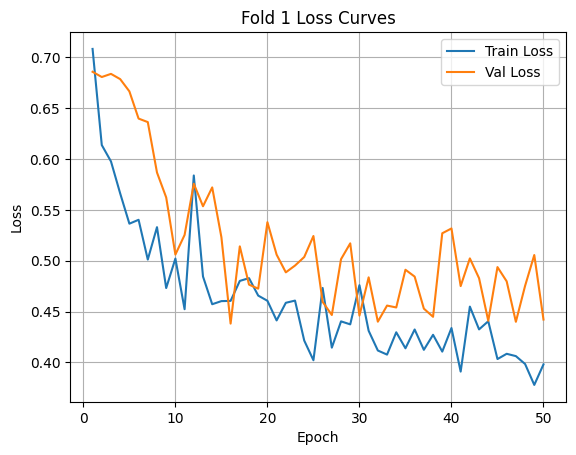


Starting Fold 2/5
Training size: 225 | Validation size: 56
Fold 2 Epoch [1/50] Train Loss: 0.7354 Train Acc: 0.5644 | Val Loss: 0.6823 Val Acc: 0.5893
Fold 2 Epoch [2/50] Train Loss: 0.6089 Train Acc: 0.7067 | Val Loss: 0.6799 Val Acc: 0.5714
Fold 2 Epoch [3/50] Train Loss: 0.5759 Train Acc: 0.7244 | Val Loss: 0.6729 Val Acc: 0.5714
Fold 2 Epoch [4/50] Train Loss: 0.5309 Train Acc: 0.7556 | Val Loss: 0.6609 Val Acc: 0.5893
Fold 2 Epoch [5/50] Train Loss: 0.5108 Train Acc: 0.7733 | Val Loss: 0.6271 Val Acc: 0.6964
Fold 2 Epoch [6/50] Train Loss: 0.5471 Train Acc: 0.7244 | Val Loss: 0.6062 Val Acc: 0.7500
Fold 2 Epoch [7/50] Train Loss: 0.4632 Train Acc: 0.7822 | Val Loss: 0.5751 Val Acc: 0.7500
Fold 2 Epoch [8/50] Train Loss: 0.5133 Train Acc: 0.7556 | Val Loss: 0.5343 Val Acc: 0.7679
Fold 2 Epoch [9/50] Train Loss: 0.5320 Train Acc: 0.7556 | Val Loss: 0.5376 Val Acc: 0.7321
Fold 2 Epoch [10/50] Train Loss: 0.5256 Train Acc: 0.7600 | Val Loss: 0.5316 Val Acc: 0.7500
Fold 2 Epoch [11/50

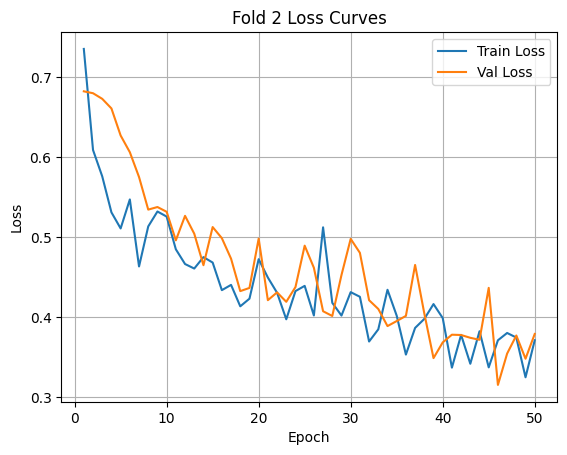


Starting Fold 3/5
Training size: 225 | Validation size: 56
Fold 3 Epoch [1/50] Train Loss: 0.6799 Train Acc: 0.5689 | Val Loss: 0.6756 Val Acc: 0.5714
Fold 3 Epoch [2/50] Train Loss: 0.5856 Train Acc: 0.6533 | Val Loss: 0.6897 Val Acc: 0.5714
Fold 3 Epoch [3/50] Train Loss: 0.6087 Train Acc: 0.7022 | Val Loss: 0.7059 Val Acc: 0.5714
Fold 3 Epoch [4/50] Train Loss: 0.5625 Train Acc: 0.7333 | Val Loss: 0.7206 Val Acc: 0.5179
Fold 3 Epoch [5/50] Train Loss: 0.5343 Train Acc: 0.7422 | Val Loss: 0.6946 Val Acc: 0.5536
Fold 3 Epoch [6/50] Train Loss: 0.5151 Train Acc: 0.7689 | Val Loss: 0.6873 Val Acc: 0.5893
Fold 3 Epoch [7/50] Train Loss: 0.5372 Train Acc: 0.7422 | Val Loss: 0.6585 Val Acc: 0.6607
Fold 3 Epoch [8/50] Train Loss: 0.5157 Train Acc: 0.7644 | Val Loss: 0.6065 Val Acc: 0.7143
Fold 3 Epoch [9/50] Train Loss: 0.5410 Train Acc: 0.7422 | Val Loss: 0.5743 Val Acc: 0.7857
Fold 3 Epoch [10/50] Train Loss: 0.4786 Train Acc: 0.7956 | Val Loss: 0.5357 Val Acc: 0.8214
Fold 3 Epoch [11/50

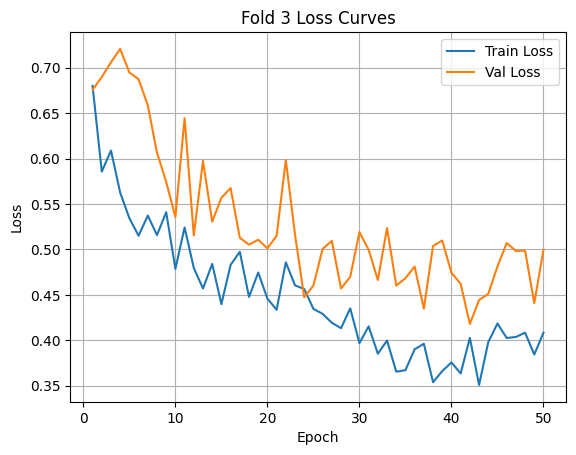


Starting Fold 4/5
Training size: 225 | Validation size: 56
Fold 4 Epoch [1/50] Train Loss: 0.6961 Train Acc: 0.5911 | Val Loss: 0.6839 Val Acc: 0.5536
Fold 4 Epoch [2/50] Train Loss: 0.5756 Train Acc: 0.7422 | Val Loss: 0.6722 Val Acc: 0.5714
Fold 4 Epoch [3/50] Train Loss: 0.6161 Train Acc: 0.6667 | Val Loss: 0.6586 Val Acc: 0.6071
Fold 4 Epoch [4/50] Train Loss: 0.5649 Train Acc: 0.7422 | Val Loss: 0.6572 Val Acc: 0.6429
Fold 4 Epoch [5/50] Train Loss: 0.5665 Train Acc: 0.7378 | Val Loss: 0.6603 Val Acc: 0.6250
Fold 4 Epoch [6/50] Train Loss: 0.5232 Train Acc: 0.7556 | Val Loss: 0.6183 Val Acc: 0.7321
Fold 4 Epoch [7/50] Train Loss: 0.5252 Train Acc: 0.7467 | Val Loss: 0.5831 Val Acc: 0.8036
Fold 4 Epoch [8/50] Train Loss: 0.5628 Train Acc: 0.7644 | Val Loss: 0.5399 Val Acc: 0.7500
Fold 4 Epoch [9/50] Train Loss: 0.5036 Train Acc: 0.7867 | Val Loss: 0.5208 Val Acc: 0.7321
Fold 4 Epoch [10/50] Train Loss: 0.5527 Train Acc: 0.7378 | Val Loss: 0.5311 Val Acc: 0.7857
Fold 4 Epoch [11/50

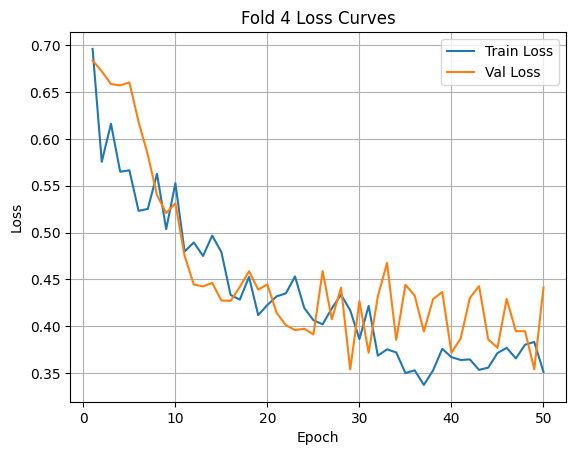


Starting Fold 5/5
Training size: 225 | Validation size: 56
Fold 5 Epoch [1/50] Train Loss: 0.7178 Train Acc: 0.5956 | Val Loss: 0.6760 Val Acc: 0.5714
Fold 5 Epoch [2/50] Train Loss: 0.6353 Train Acc: 0.6578 | Val Loss: 0.6895 Val Acc: 0.5714
Fold 5 Epoch [3/50] Train Loss: 0.6089 Train Acc: 0.6933 | Val Loss: 0.6986 Val Acc: 0.5714
Fold 5 Epoch [4/50] Train Loss: 0.5425 Train Acc: 0.7200 | Val Loss: 0.6960 Val Acc: 0.5714
Fold 5 Epoch [5/50] Train Loss: 0.5557 Train Acc: 0.7067 | Val Loss: 0.6868 Val Acc: 0.5893
Fold 5 Epoch [6/50] Train Loss: 0.5398 Train Acc: 0.7244 | Val Loss: 0.6647 Val Acc: 0.6607
Fold 5 Epoch [7/50] Train Loss: 0.5069 Train Acc: 0.7422 | Val Loss: 0.6209 Val Acc: 0.6786
Fold 5 Epoch [8/50] Train Loss: 0.5194 Train Acc: 0.7689 | Val Loss: 0.6068 Val Acc: 0.6964
Fold 5 Epoch [9/50] Train Loss: 0.5088 Train Acc: 0.7689 | Val Loss: 0.6223 Val Acc: 0.6964
Fold 5 Epoch [10/50] Train Loss: 0.4901 Train Acc: 0.7556 | Val Loss: 0.5519 Val Acc: 0.7321
Fold 5 Epoch [11/50

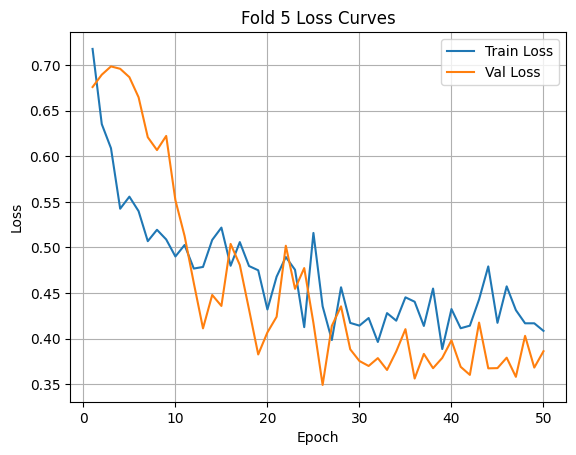


Cross Validation Complete.
Average Validation Accuracy over 5 folds: 0.8756
Best Fold Validation Accuracy: 0.9286


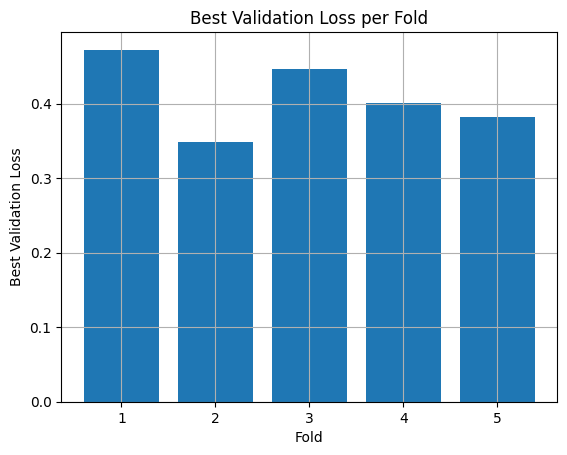

Best model saved to 'best_dgcnn_model.pth'

Test Loss: 0.5457 Test Accuracy: 0.8061
Confusion Matrix:
[[15 13]
 [ 6 64]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.54      0.61        28
           1       0.83      0.91      0.87        70

    accuracy                           0.81        98
   macro avg       0.77      0.72      0.74        98
weighted avg       0.80      0.81      0.80        98



In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ------------------------
# Helper functions for DGCNN
# ------------------------

def knn(x, k):
    inner = -2 * torch.matmul(x.transpose(2, 1), x)  # (B, N, N)
    xx = torch.sum(x ** 2, dim=1, keepdim=True)  # (B, 1, N)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)  # (B, N, N)
    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (B, N, k)
    return idx

def get_graph_feature(x, k=20, idx=None):
    batch_size, num_dims, num_points = x.size()
    if idx is None:
        idx = knn(x, k=k)
    device = x.device
    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1) * num_points
    idx = idx + idx_base
    idx = idx.view(-1)
    x = x.transpose(2, 1).contiguous()  # (B, N, C)
    feature = x.view(batch_size * num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims)
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)
    feature = torch.cat((feature - x, x), dim=3).permute(0, 3, 1, 2).contiguous()
    return feature

# ------------------------
# DGCNN Model Definition
# ------------------------

class DGCNNClassifier(nn.Module):
    def __init__(self, k=20, emb_dims=1024, num_classes=2, dropout=0.5):
        super(DGCNNClassifier, self).__init__()
        self.k = k
        self.bn1 = nn.BatchNorm2d(64)
        self.conv1 = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=1, bias=False),
            self.bn1,
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.bn2 = nn.BatchNorm2d(64)
        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=1, bias=False),
            self.bn2,
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.bn3 = nn.BatchNorm2d(128)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=1, bias=False),
            self.bn3,
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.bn4 = nn.BatchNorm2d(256)
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1, bias=False),
            self.bn4,
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(512, emb_dims, kernel_size=1, bias=False),
            nn.BatchNorm1d(emb_dims),
            nn.LeakyReLU(negative_slope=0.2)
        )
        self.linear1 = nn.Linear(emb_dims * 2, 512, bias=False)
        self.bn6 = nn.BatchNorm1d(512)
        self.dp1 = nn.Dropout(p=dropout)
        self.linear2 = nn.Linear(512, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.dp2 = nn.Dropout(p=dropout)
        self.linear3 = nn.Linear(256, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.transpose(2, 1)  # (B, 3, N)
        x = get_graph_feature(x, k=self.k)  # (B, 6, N, k)
        x = self.conv1(x)                   # (B, 64, N, k)
        x1 = x.max(dim=-1, keepdim=False)[0] # (B, 64, N)

        x = get_graph_feature(x1, k=self.k)  # (B, 128, N, k)
        x = self.conv2(x)                   # (B, 64, N, k)
        x2 = x.max(dim=-1, keepdim=False)[0] # (B, 64, N)

        x = get_graph_feature(x2, k=self.k)  # (B, 128, N, k)
        x = self.conv3(x)                   # (B, 128, N, k)
        x3 = x.max(dim=-1, keepdim=False)[0] # (B, 128, N)

        x = get_graph_feature(x3, k=self.k)  # (B, 256, N, k)
        x = self.conv4(x)                   # (B, 256, N, k)
        x4 = x.max(dim=-1, keepdim=False)[0] # (B, 256, N)

        x = torch.cat((x1, x2, x3, x4), dim=1)  # (B, 512, N)
        x = self.conv5(x)                     # (B, emb_dims, N)

        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1)
        x = torch.cat((x1, x2), 1)            # (B, emb_dims*2)

        x = F.leaky_relu(self.bn6(self.linear1(x)), negative_slope=0.2)
        x = self.dp1(x)
        x = F.leaky_relu(self.bn7(self.linear2(x)), negative_slope=0.2)
        x = self.dp2(x)
        x = self.linear3(x)
        return x

# ------------------------
# Training and Evaluation Functions
# ------------------------

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch in dataloader:
        pointclouds = batch["pointcloud"].to(device)  # (B, num_points, 3)
        labels = batch["label"].to(device)             # (B,)

        if pointclouds.size(0) <= 1:
            continue

        optimizer.zero_grad()
        outputs = model(pointclouds)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * pointclouds.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

    if total == 0:
        return 0.0, 0.0
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            pointclouds = batch["pointcloud"].to(device)
            labels = batch["label"].to(device)

            if pointclouds.size(0) <= 1:
                continue

            outputs = model(pointclouds)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * pointclouds.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    if total == 0:
        return 0.0, 0.0, None, None
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_labels, all_preds

# ------------------------
# Process Sequences Function
# ------------------------

def process_sequences(seq_list, base_path, set_name="Set"):
    ds_list = []
    for seq in seq_list:
        seq_path = os.path.join(base_path, seq)
        if "harvard_tea_2" in seq:
            depth_folder = "depth"
        else:
            depth_folder = "depthTSDF"
        annotation_path = "labels/tabletop_labels.dat"
        intrinsics_path = os.path.join(seq_path, "intrinsics.txt")
        dataset = TableClassificationDataset(
            root_dir=seq_path,
            depth_folder=depth_folder,
            annotation_path=annotation_path,
            intrinsics_path=intrinsics_path,
            num_points=1024,
            transform=random_augmentation,
            verbose=False
        )
        pos_count = sum(1 for i in range(len(dataset)) if dataset[i]["label"].item() == 1)
        neg_count = len(dataset) - pos_count
        print(f"{set_name} '{seq}' has {len(dataset)} PNG depth images: {pos_count} positives, {neg_count} negatives.")
        ds_list.append(dataset)
    combined = ConcatDataset(ds_list)
    total_pos = sum(1 for i in range(len(combined)) if combined[i]["label"].item() == 1)
    total_neg = len(combined) - total_pos
    print(f"{set_name} Combined dataset has {len(combined)} images: {total_pos} positives, {total_neg} negatives.")
    return combined

# ------------------------
# Main Training Script with 5-Fold Cross Validation (using StratifiedKFold) and ReduceLROnPlateau
# and final evaluation with confusion matrix on the Test Set
# ------------------------

def main():
    # Hyperparameters
    batch_size = 64
    num_epochs = 50
    learning_rate = 0.0001
    weight_decay = 1e-4  # L2 regularization
    k_val = 20
    emb_dims = 1024
    dropout = 0.5
    num_classes = 2
    n_splits = 5

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    base_path = "CW2-Dataset/data/"
    sequences_train = [
        "mit_32_d507/d507_2",
        "mit_76_459/76-459b",
        "mit_76_studyroom/76-1studyroom2",
        "mit_gym_z_squash/gym_z_squash_scan1_oct_26_2012_erika",
        "mit_lab_hj/lab_hj_tea_nov_2_2012_scan1_erika"
    ]
    sequences_test = [
        "harvard_c5/hv_c5_1",
        "harvard_c6/hv_c6_1",
        "harvard_c11/hv_c11_2",
        "harvard_tea_2/hv_tea2_2"
    ]

    print("Processing Training Sequences:")
    train_full_dataset = process_sequences(sequences_train, base_path, set_name="Train")

    print("\nProcessing Test Sequences:")
    test_dataset = process_sequences(sequences_test, base_path, set_name="Test")

    # Create label array for StratifiedKFold
    labels = [train_full_dataset[i]["label"].item() for i in range(len(train_full_dataset))]

    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_val_accs = []
    fold_val_losses = []
    best_fold_model_state = None
    best_fold_val_acc = 0.0
    all_fold_train_losses = []
    all_fold_val_losses = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
        print(f"\nStarting Fold {fold+1}/{n_splits}")
        print(f"Training size: {len(train_idx)} | Validation size: {len(val_idx)}")
        train_subset = Subset(train_full_dataset, train_idx)
        val_subset = Subset(train_full_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)

        model = DGCNNClassifier(k=k_val, emb_dims=emb_dims, num_classes=num_classes, dropout=dropout)
        model = model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # Use ReduceLROnPlateau to adjust learning rate when validation loss plateaus
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

        best_val_acc_fold = 0.0
        best_val_loss_fold = float('inf')
        train_losses_fold = []
        val_losses_fold = []

        for epoch in range(num_epochs):
            train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
            train_losses_fold.append(train_loss)
            val_losses_fold.append(val_loss)
            print(f"Fold {fold+1} Epoch [{epoch+1}/{num_epochs}] "
                  f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
            scheduler.step(val_loss)
            if val_acc > best_val_acc_fold:
                best_val_acc_fold = val_acc
                best_val_loss_fold = val_loss
                best_model_state_fold = model.state_dict()

        print(f"Fold {fold+1} Best Val Acc: {best_val_acc_fold:.4f} with Loss: {best_val_loss_fold:.4f}")
        fold_val_accs.append(best_val_acc_fold)
        fold_val_losses.append(best_val_loss_fold)
        all_fold_train_losses.append(train_losses_fold)
        all_fold_val_losses.append(val_losses_fold)

        if best_val_acc_fold > best_fold_val_acc:
            best_fold_val_acc = best_val_acc_fold
            best_fold_model_state = best_model_state_fold

        # Plot loss curves for this fold
        epochs_arr = np.arange(1, num_epochs + 1)
        plt.figure()
        plt.plot(epochs_arr, train_losses_fold, label="Train Loss")
        plt.plot(epochs_arr, val_losses_fold, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Fold {fold+1} Loss Curves")
        plt.legend()
        plt.grid(True)
        plt.show()

    print("\nCross Validation Complete.")
    print(f"Average Validation Accuracy over {n_splits} folds: {np.mean(fold_val_accs):.4f}")
    print(f"Best Fold Validation Accuracy: {best_fold_val_acc:.4f}")

    plt.figure()
    plt.bar(np.arange(1, n_splits+1), fold_val_losses, tick_label=np.arange(1, n_splits+1))
    plt.xlabel("Fold")
    plt.ylabel("Best Validation Loss")
    plt.title("Best Validation Loss per Fold")
    plt.grid(True)
    plt.show()

    torch.save(best_fold_model_state, "best_dgcnn_model.pth")
    print("Best model saved to 'best_dgcnn_model.pth'")


    # Evaluate best model on the test set
    model = DGCNNClassifier(k=k_val, emb_dims=emb_dims, num_classes=num_classes, dropout=dropout)
    model.load_state_dict(torch.load("best_dgcnn_model.pth"))
    model = model.to(device)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion, device)
    print(f"\nTest Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(cr)

if __name__ == "__main__":
    main()


Loaded intrinsics from CW2-Dataset/data/harvard_c5/hv_c5_1/intrinsics.txt:
[[570.34220474   0.         320.        ]
 [  0.         570.34220474 240.        ]
 [  0.           0.           1.        ]]


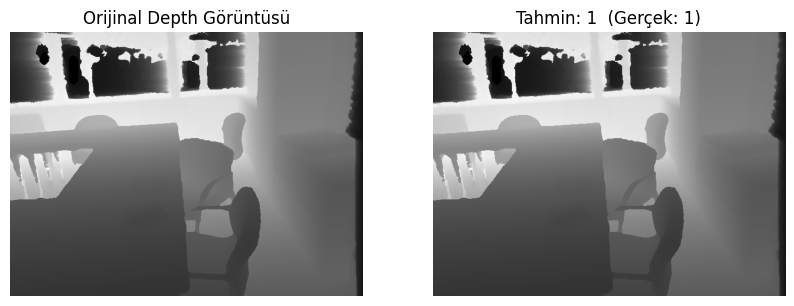

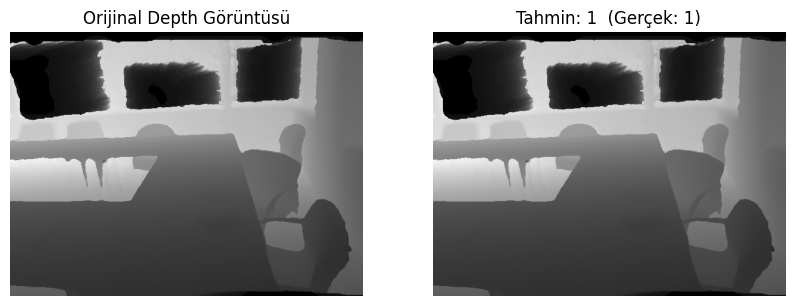

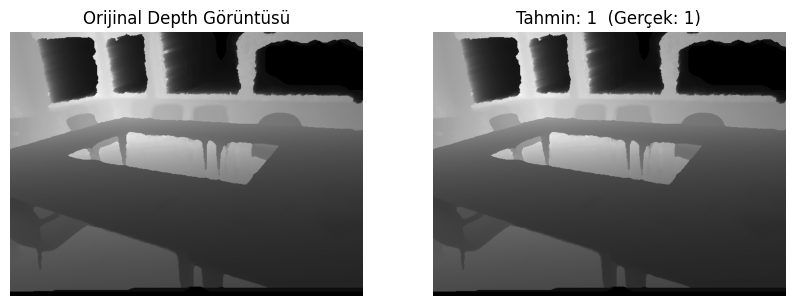

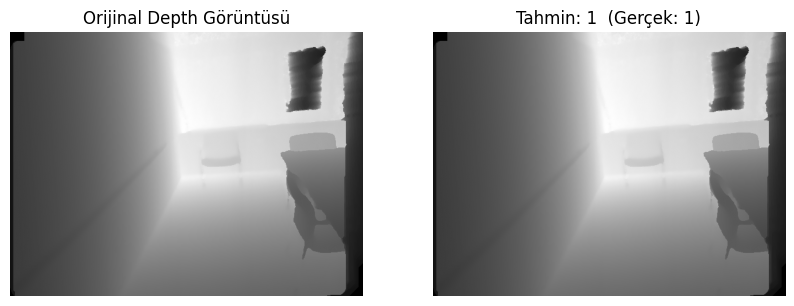

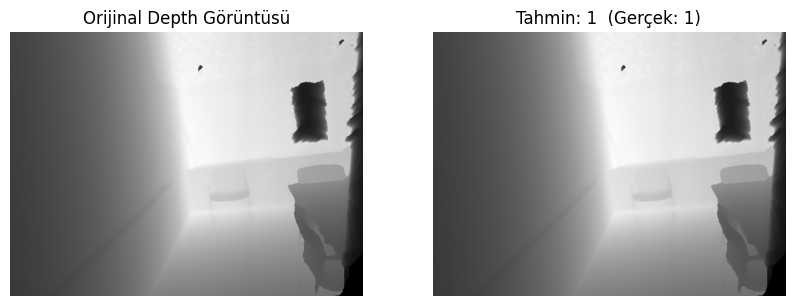

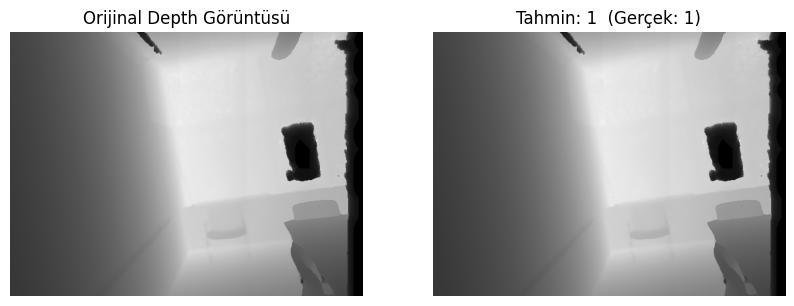

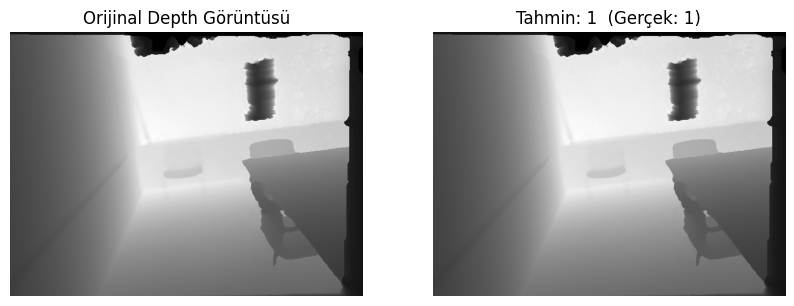

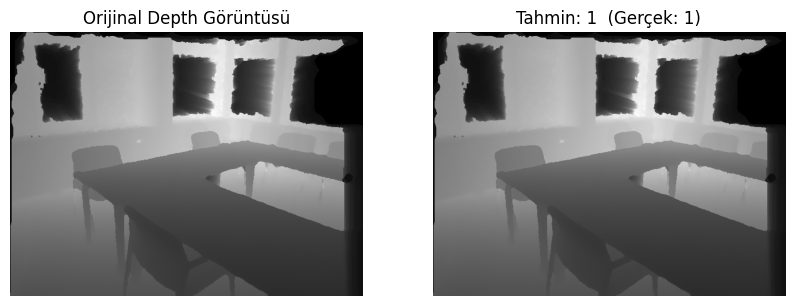

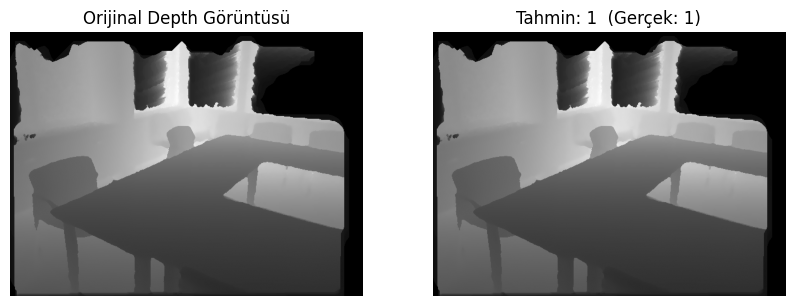

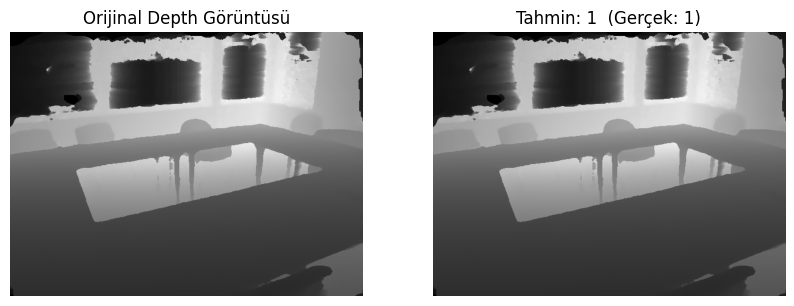

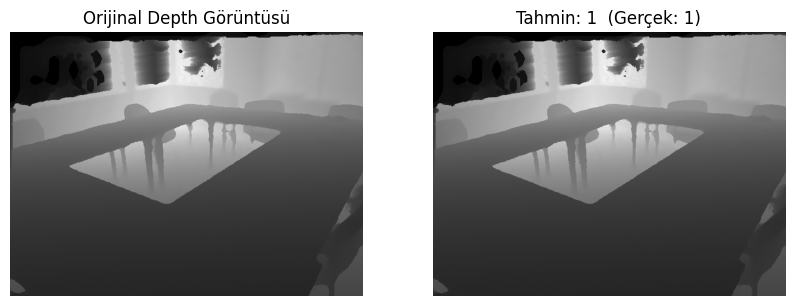

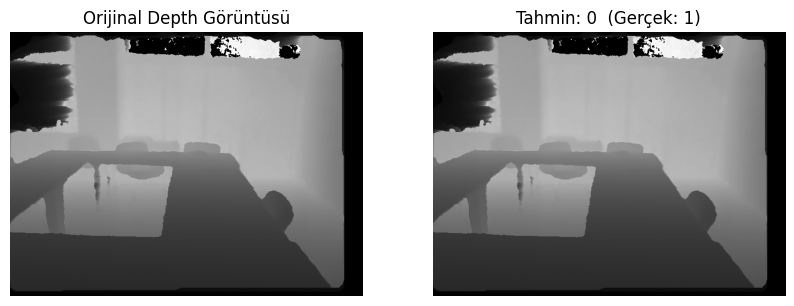

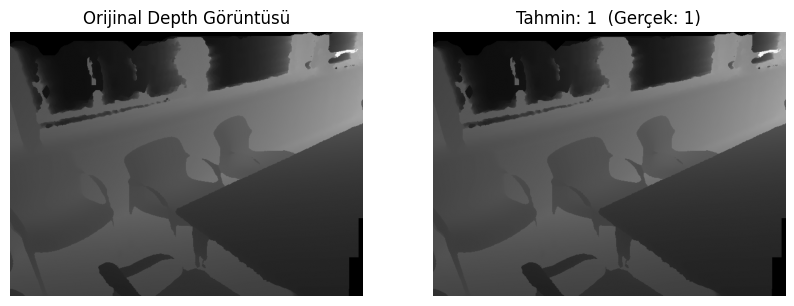

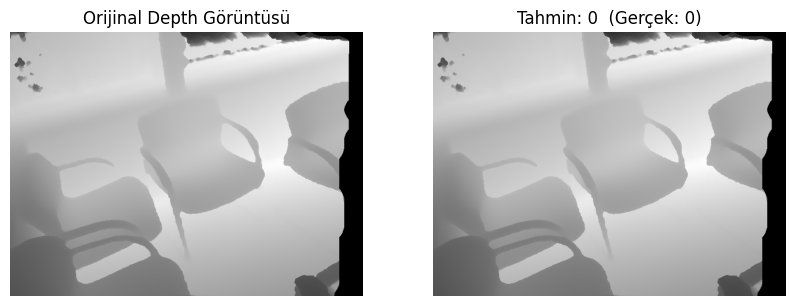

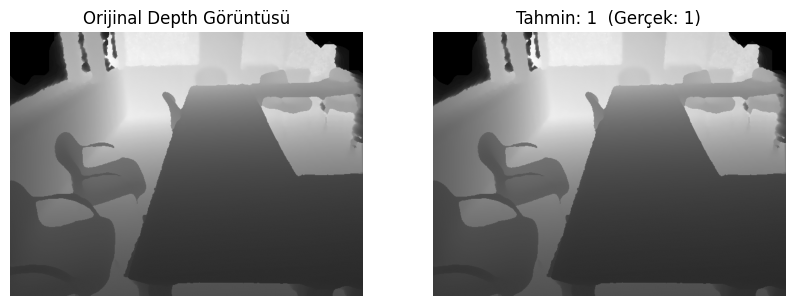

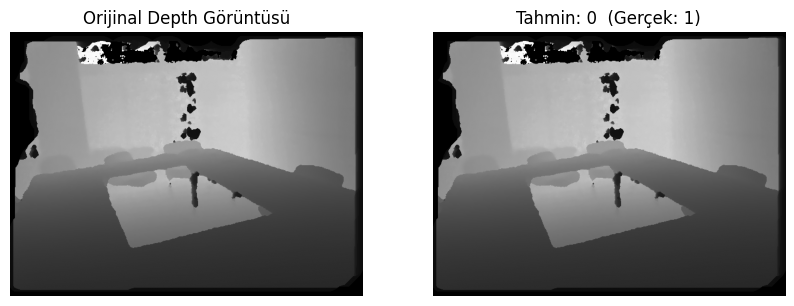

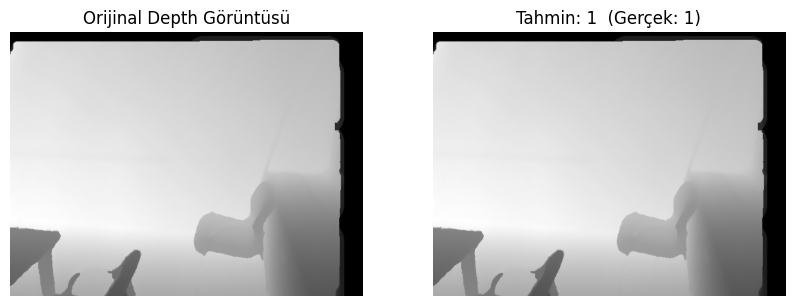

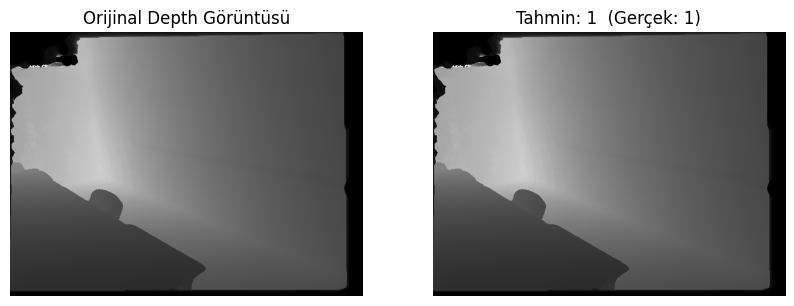

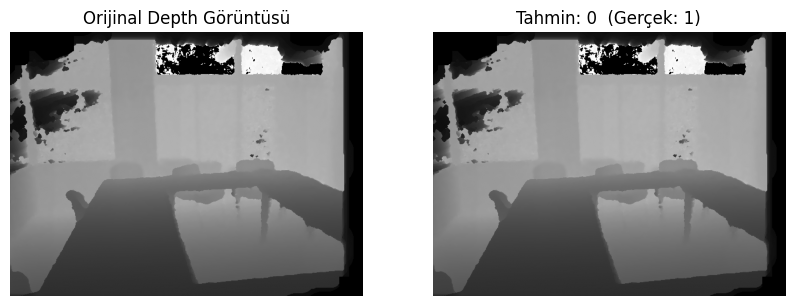

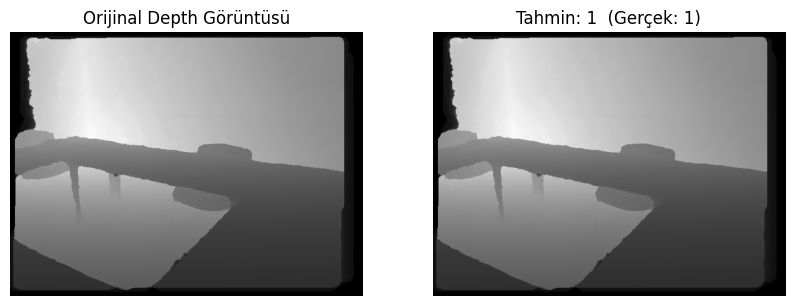

In [ ]:
import os
import torch
import cv2
import matplotlib.pyplot as plt

# Görselleştirme için, dataset'e dosya adını da ekleyecek alt sınıf tanımlayalım:
class VisualizationDataset(TableClassificationDataset):
    def __getitem__(self, idx):
        sample = super().__getitem__(idx)
        # Dataset içindeki orijinal depth dosyalarının adını da döndür
        sample["filename"] = self.depth_files[idx]
        return sample

def visualize_test_set(test_dataset, model, device, num_samples=10):
    model.eval()
    # Görüntülemek istediğimiz örnek sayısı kadar iterasyon yapıyoruz.
    for i in range(num_samples):
        sample = test_dataset[i]
        filename = sample["filename"]
        # Dosya yolunu oluştur: test_dataset'in root_dir ve depth folder bilgisini kullanıyoruz.
        img_path = os.path.join(test_dataset.root_dir, os.path.basename(test_dataset.depth_dir), filename)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            continue
        # Model tahmini için pointcloud'u alın (batch boyutunu 1'e ekleyerek)
        pointcloud = sample["pointcloud"].unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(pointcloud)
            pred = torch.argmax(output, dim=1).item()
        gt = sample["label"].item()

        # Görselleştirme: orijinal görüntüyü ve tahmini yan yana göster.
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(img, cmap='gray')
        plt.title("Orijinal Depth Görüntüsü")
        plt.axis("off")
        plt.subplot(1,2,2)
        plt.imshow(img, cmap='gray')
        plt.title(f"Tahmin: {pred}  (Gerçek: {gt})")
        plt.axis("off")
        plt.show()

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Örneğin, test seti olarak harvard_c5 sekansını kullanıyoruz.
    base_path = "CW2-Dataset/data/"
    seq = "harvard_c5/hv_c5_1"
    seq_path = os.path.join(base_path, seq)
    # Raw depth görüntüleri için "depth" kullanılıyorsa, depth_folder'ı "depth" yapın.
    # Eğer önceden işlenmiş (TSDF) ise "depthTSDF" kullanabilirsiniz.
    depth_folder = "depthTSDF"  # Burada raw depth görüntüler olduğu varsayılıyor.
    annotation_path = "labels/tabletop_labels.dat"
    intrinsics_path = os.path.join(seq_path, "intrinsics.txt")

    # Görselleştirme için augmentasyon kapalı (transform=None)
    test_dataset = VisualizationDataset(
        root_dir=seq_path,
        depth_folder=depth_folder,
        annotation_path=annotation_path,
        intrinsics_path=intrinsics_path,
        num_points=1024,
        transform=None,
        verbose=False
    )

    # En iyi model dosyasını yükle
    model = DGCNNClassifier(k=20, emb_dims=1024, num_classes=2, dropout=0.5)
    model.load_state_dict(torch.load("best_dgcnn_model.pth", map_location=device))
    model = model.to(device)

    # Test setinde belirli sayıda örneği görselleştir (örneğin 10 adet)
    visualize_test_set(test_dataset, model, device, num_samples=20)

if __name__ == "__main__":
    main()
